In [1]:
import numpy as np
import tensorflow as tf
import keras.api as keras
from keras.api.layers import *
import matplotlib.pyplot as plt

2025-03-24 11:38:22.361934: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742827102.377425  291023 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742827102.381951  291023 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 11:38:22.397680: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


I0000 00:00:1742827106.319904  291023 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10152 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


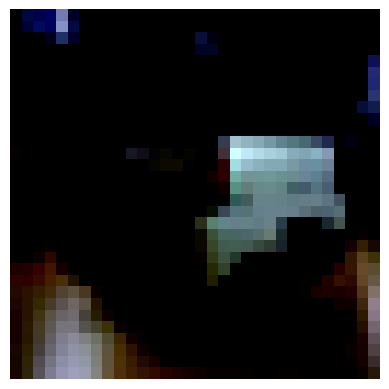

In [2]:
(x_train,y_train),(_,_) = keras.datasets.cifar10.load_data()

x_train = x_train[y_train[:,0] == 1]
x_train = (tf.cast(x_train,tf.float32)-127.5) / 127.5

n = np.random.randint(0,x_train.shape[0])

batch_size = 128

data = tf.data.Dataset.from_tensor_slices((x_train)).shuffle(x_train.shape[0]).batch(batch_size,drop_remainder=True)

complete_hist = {
    'loss_dis': [],
    'loss_gen': [],
}

plt.imshow(x_train[n])
plt.axis(False)
plt.show()

In [3]:
class miniBatch(keras.layers.Layer):
    def __init__(self,num_kernels,kernel_dim,batch_size):
        super(miniBatch,self).__init__()
        self.num_kernels = num_kernels
        self.kernel_dim = kernel_dim
        self.batch_size = batch_size
    
    def build(self, input_shape):
        print(input_shape)
        self.T = self.add_weight(
            shape=(input_shape[-1],self.num_kernels*self.kernel_dim), # Teoricamente 128x500
            initializer='random_normal',
            trainable=True,
        )

    def call(self, x):
        M = tf.matmul(x,self.T) # teoricamente 128x128 \times 128x500 = 128x500
        M = tf.reshape(M,(-1,self.num_kernels,self.kernel_dim)) # teoricamente 128x100x5
        M_T = tf.expand_dims(M,1) # teoricamente 128x1x100x5
        M = tf.expand_dims(M,0) # teoricamente 1x128x100x5
        diff = tf.abs(M-M_T)
        exp_diff = tf.exp(-tf.reduce_mean(diff,-1))
        miniBatch_features = tf.reduce_sum(exp_diff,1)
        output = tf.concat([x,miniBatch_features],-1)
        return output
    
    def compute_output_shape(self, input_shape):
        # Define a forma de saída explicitamente
        return (input_shape[0], input_shape[1] + self.num_kernels)

class PixelShuffle(keras.layers.Layer):
    def __init__(self, upscale_factor):
        super(PixelShuffle, self).__init__()
        self.upscale_factor = upscale_factor

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        h = input_shape[1]
        w = input_shape[2]
        c = input_shape[3]
        out_c = c // (self.upscale_factor ** 2)
        x = tf.reshape(inputs, (batch_size, h, w, self.upscale_factor, self.upscale_factor, out_c))
        x = tf.transpose(x, [0, 1, 2, 4, 3, 5])
        x = tf.reshape(x, (batch_size, h * self.upscale_factor, w * self.upscale_factor, out_c))
        return x
    
    def compute_output_shape(self, input_shape):
        h, w, c = input_shape[1], input_shape[2], input_shape[3]
        out_c = c // (self.upscale_factor ** 2)
        return (input_shape[0], h * self.upscale_factor, w * self.upscale_factor, out_c)
    

class SelfAttention(Layer):
    def __init__(self, filters):
        super(SelfAttention, self).__init__()
        self.filters = filters
        self.query_conv = Conv2D(filters // 8, kernel_size=1)
        self.key_conv = Conv2D(filters // 8, kernel_size=1)
        self.value_conv = Conv2D(filters, kernel_size=1)
        self.softmax = Softmax(axis=-1)
    
    def call(self, x):
        batch, height, width, channels = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]

        Q = tf.reshape(self.query_conv(x), (batch, height * width, -1))  # [B, HW, C/8]
        K = tf.reshape(self.key_conv(x), (batch, -1, height * width))    # [B, C/8, HW]
        V = tf.reshape(self.value_conv(x), (batch, height * width, -1))  # [B, HW, C]

        attention_map = self.softmax(tf.matmul(Q, K))  # [B, HW, HW]

        attention_output = tf.matmul(attention_map, V)  # [B, HW, C]
        attention_output = tf.reshape(attention_output, (batch, height, width, channels))

        return attention_output + x



    
def residual_Gblock(x):

    skip = x
    x = Conv2D(x.shape[-1],3,1,'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(.2)(x)
    x = Conv2D(x.shape[-1],3,1,'same')(x)
    x = Add()([x,skip])

    return x

def residual_Dblock(x):

    skip = x
    x = Conv2D(x.shape[-1],3,1,'same')(x)
    x = LeakyReLU(.2)(x)
    x = Conv2D(x.shape[-1],3,1,'same')(x)
    x = Add()([x,skip])
    x = LeakyReLU(.2)(x)

    return x


def create_discriminator():
    
    input = Input((32,32,3))
    x = input
    k = 1
    for _ in range(4):
        x = Conv2D(512//k,3,2,'same')(x)
        x = LeakyReLU(.2)(x)
        k = k*2

    x = Flatten()(x)
    x = miniBatch(100,5,128)(x)
    x = Dropout(.3)(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    

    return keras.Model(input,x,name='Discriminator')

def create_generator():

    input = Input((128,))

    x = Dense(8*8*2048)(input)
    x = LeakyReLU(.2)(x)
    x = BatchNormalization()(x)
    x = Reshape((8,8,2048))(x)
    x = SelfAttention(x.shape[-1])(x)

    for _ in range(2):
        x = Conv2DTranspose(256,3,1,'same')(x)
        x = UpSampling2D()(x)
        x = LeakyReLU(.2)(x)
        x = BatchNormalization()(x)

    x = Conv2D(3,3,1,'same')(x)
    x = Activation('tanh')(x)

    return keras.Model(input,x)

gen = create_generator()
dis = create_discriminator()
dis.summary()
gen.summary()

(None, 256)


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 512)    │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 2, 2, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mini_batch (miniBatch)          │ (None, 356)            │       128,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 356)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           357 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,691,429 (6.45 MB)

 Trainable params: 1,691,429 (6.45 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 131072)         │    16,908,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 131072)         │       524,288 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention (SelfAttention)  │ (None, 8, 8, 2048)     │     5,245,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │     4,718,848 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 3)      │         6,915 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,995,907 (106.80 MB)

 Trainable params: 27,732,739 (105.79 MB)

 Non-trainable params: 263,168 (1.00 MB)

In [4]:
bce = keras.losses.BinaryCrossentropy()
MSE = keras.losses.MeanSquaredError()

LR = 1e-4

gen_opt = keras.optimizers.Adam(LR,.5)
dis_opt = keras.optimizers.Adam(LR/2,.5)
n = 5
noise_out = tf.random.normal((n**2,128))

In [5]:
for i,layer in enumerate(dis.layers):
    print(f'L = {i}, layer = {layer}')

#n = np.random.uniform(0,1,(1,32,32,3))

maps = keras.Model(dis.input, dis.layers[7].output)
# map = maps(n)

L = 0, layer = <InputLayer name=input_layer_1, built=True>
L = 1, layer = <Conv2D name=conv2d_4, built=True>
L = 2, layer = <LeakyReLU name=leaky_re_lu_3, built=True>
L = 3, layer = <Conv2D name=conv2d_5, built=True>
L = 4, layer = <LeakyReLU name=leaky_re_lu_4, built=True>
L = 5, layer = <Conv2D name=conv2d_6, built=True>
L = 6, layer = <LeakyReLU name=leaky_re_lu_5, built=True>
L = 7, layer = <Conv2D name=conv2d_7, built=True>
L = 8, layer = <LeakyReLU name=leaky_re_lu_6, built=True>
L = 9, layer = <Flatten name=flatten, built=True>
L = 10, layer = <miniBatch name=mini_batch, built=True>
L = 11, layer = <Dropout name=dropout, built=True>
L = 12, layer = <Dense name=dense_1, built=True>
L = 13, layer = <Activation name=activation_1, built=True>


In [6]:
def clip_weights(model,clip_value=0.1):
    
    for layer in model.trainable_variables:
        layer.assign(tf.clip_by_value(layer, -clip_value, clip_value))

# def gradient_penalty(discriminator, real_samples, fake_samples):
#     alpha = tf.random.uniform((real_samples.shape[0],), 0, 1)
#     interpolated_samples = alpha[0] * real_samples + (1 - alpha[0]) * fake_samples
#     with tf.GradientTape() as tape:
#         tape.watch(interpolated_samples)
#         predictions = discriminator(interpolated_samples)
#     gradients = tape.gradient(predictions, interpolated_samples)
#     gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=1))
#     penalty = tf.reduce_mean((gradients_norm - 1) ** 2)
#     return penalty

# def wasser_dist(y_true,y_pred):
#     return tf.reduce_mean(y_true * y_pred)




@tf.function
def train_step():
    gen_loss,dis_loss = 0.,0.
    gen_loss_iter,dis_loss_iter = 0.,0.
    for batch in data:
        
        noise = tf.random.normal((batch_size,128))

        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
            fake_imgs = gen(noise,training=True)
            true_labels = dis(batch,training=True)
            fake_labels = dis(fake_imgs,training=True)
            #true_map = maps(batch,training=True)
            #fake_map = maps(fake_imgs, training=True)

            
            gen_loss_iter = bce(tf.ones_like(fake_labels),fake_labels) #- (1/2)*tf.reduce_mean(tf.math.reduce_std(fake_imgs,axis=0))
            dis_loss_iter = bce(tf.ones_like(true_labels),true_labels) + bce(tf.zeros_like(fake_labels),fake_labels)
            # dis_loss_iter = tf.reduce_mean(fake_labels) - tf.reduce_mean(true_labels)
            # gen_loss_iter = -tf.reduce_mean(fake_labels) + MSE(true_map,fake_map)
        
        gen_gras = gen_tape.gradient(gen_loss_iter,gen.trainable_variables)
        gen_opt.apply_gradients(zip(gen_gras,gen.trainable_variables))

        dis_grads = dis_tape.gradient(dis_loss_iter,dis.trainable_variables)
        dis_opt.apply_gradients(zip(dis_grads,dis.trainable_variables))

        gen_loss += gen_loss_iter
        dis_loss += dis_loss_iter
        gen_loss_iter,dis_loss_iter = 0.,0.

    return gen_loss/tf.cast(len(data),tf.float32),dis_loss/tf.cast(len(data),tf.float32)

In [ ]:
EPOCHS = 5000
EPOCH_SAMPLE = 10

loss_dis, loss_gen = 0.,0.

for i in range(EPOCHS):

    # Histórico de Loss
    
    loss_gen, loss_dis = train_step()
    #loss_gen, loss_dis = loss_gen.numpy(), loss_dis.numpy()
    clip_weights(dis,0.1)
    complete_hist['loss_gen'].append(loss_gen)
    complete_hist['loss_dis'].append(loss_dis)
    
    # Iteração das épocas
    if i % EPOCH_SAMPLE == 0:
        # Print Loss
        print(f'Ep = {i} | Loss_gen = {loss_gen:.4f}; Loss_dis = {loss_dis:.4f}')
        # Salvar uma amostra das imagens
        img_fake = gen(noise_out)
        fig, ax = plt.subplots(n,n,figsize=(1,1))
        ax = ax.ravel()
        for ii in range(n**2):
            ax[ii].imshow(np.uint8(img_fake[ii]*127.5+127.5))
            ax[ii].set_axis_off()
        plt.savefig(f'imgs/fig{i}.png',dpi=1000)
        plt.close()

    plt.semilogy(np.array(complete_hist['loss_gen']),label=f'GEN = {loss_gen:.4f}')
    plt.semilogy(np.array(complete_hist['loss_dis']),label=f'DIS = {loss_dis:.4f}')
    plt.legend()
    plt.grid(True,'minor')
    plt.savefig('loss.png')
    plt.close()


print('==================== COMPLETE ====================')

# plt.Figure()
# plt.plot(loss_list[:,0],label='Discriminator')
# plt.plot(loss_list[:,1],label='GAN')
# plt.legend()
# plt.show()

I0000 00:00:1742827116.637846  291117 cuda_dnn.cc:529] Loaded cuDNN version 90300


Ep = 0 | Loss_gen = 1.0539; Loss_dis = 112.2770
Ep = 10 | Loss_gen = 2.3773; Loss_dis = 4.0580
Ep = 20 | Loss_gen = 1.7248; Loss_dis = 3.3013
Ep = 30 | Loss_gen = 1.3907; Loss_dis = 2.6103
Ep = 40 | Loss_gen = 1.1116; Loss_dis = 2.0926


In [ ]:
gen.save('generator_cars.keras')
dis.save('discriminator_cars.keras')

In [ ]:
n = 5

noise_out = tf.random.normal((1000,1024))

img_fake = gen(noise_out)
out_true = dis(x_train[0:1000])
out_fake = dis(gen(tf.random.uniform((1000,1024))))

print(f'Média True = {tf.reduce_mean(out_true):.4f} \nMédia False = {tf.reduce_mean(out_fake):.4f}')

plt.Figure()
plt.semilogy(np.array(complete_hist['loss_gen']),label='GEN')
plt.semilogy(np.array(complete_hist['loss_dis']),label='DIS')
plt.legend()
plt.grid(True,'minor')
plt.show()


fig, ax = plt.subplots(n,n,figsize=(10,10))
ax = ax.ravel()

for i in range(n**2):
    ax[i].imshow(img_fake[i])
    ax[i].set_axis_off()
plt.show()